
Classificador
1. Importar dados

Para criar um classificador formatar os dados da sequinte maneira:

moleculas -> uma lista/array com todos os smiles do seu banco de dados

classes -> uma lista/array de zeros e uns representando antibiótico e não antibiótico, respectivamente

O classificador vai identificar traços das moleculas e associá-los às classes, então cada molécula deverá ter o mesmo índice que sua classe.

bibliotecas sugeridas:

    pandas
    numpy



In [9]:
import pandas as pd
import numpy as np
import sklearn as sk

#Importar dados
df = pd.read_csv('/home/joao/documentos/IC-Joao/classificador/data_teste.csv',sep=';', encoding='latin-1')

#Definir a coluna das classes
labels = np.asarray(df.Classe)

#Selecionar SMILES sem as classes
df_selected = df.drop(["Classe"], axis=1)

#Codificar classes
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(labels)

labels = le.transform(labels)


2. Processamento dos dados
2.1 Encoding/padding

Nessa etapa acontece a codificação das moleculas. Pode ser tokens, one hot vector, integer vector. Você decide.

É importante que ao final do processamento todos os tokens tenham o mesmo comprimento, então um processo chamado padding precisa ser aplicado.

Por convenção as variáveis em machine learning assumem esses nomes:

X -> uma lista/array com todos os smiles codificados

y -> uma lista/array de zeros e uns representando antibiótico e não antibiótico, respectivamente

Bibliotecas sugeridas:

    numpy
    sklearn



ADIÇÕES DO TIAGO: INICIO

In [10]:
comprimentos = [len(x) for x in df_selected.Smiles.values]


In [11]:
maior_smile = np.max(comprimentos)
maior_smile

405

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

smiles = list(df_selected.Smiles.values)

table = ['Cl', 'Br', 'Na', 'Li', 'Ca', 'Al', 'Ag', 'Se', 'Mg', 'Zn', 'H', 'B', 'C', 'N', 'O', 'P', 'S', 'F', 'I', 'K', '(', ')', '[', ']', '=', '#', '@', '*', '%', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '.', '/', '\\', '+', '-', 'c', 'n', 'o', 's', 'p']


In [13]:
len(smiles)

502

In [14]:
def tokenizer(smiles,table):
    tokens_list = []
    for smile in smiles:
        i = 0
        token = []
        while i < len(smile):
            for j in table:
                if j == smile[i:i+len(j)]:
                    token.append(j)
                    i = i+len(j)
                    break
        while len(token) < maior_smile:
            token.insert(0,"A")
        tokens_list.append(token)
    return tokens_list

padded_tokens = tokenizer(smiles,table)


In [15]:
len(padded_tokens)

502

In [16]:
len(padded_tokens[0])

405

In [17]:
#Usar integer encoding ao invez de one hot
from sklearn.preprocessing import LabelEncoder
tokens_encoder = LabelEncoder()
table.append("A")
tokens_encoder.fit(table)
tokens_int_encoded = np.array([tokens_encoder.transform(i) for i in padded_tokens])


In [18]:
tokens_int_encoded

array([[21, 21, 21, ..., 10, 11, 26],
       [21, 21, 21, ..., 26, 26, 10],
       [21, 21, 21, ..., 44, 10, 37],
       ...,
       [21, 21, 21, ..., 45, 46, 10],
       [21, 21, 21, ..., 26, 26, 10],
       [21, 21, 21, ..., 45, 45, 10]])

In [19]:
tokens_int_encoded.shape

(502, 405)

ADIÇÕES DO TIAGO: FIM


3. Holdout: train/test split

Depois do processamento, seu banco de dados precisa ser dividio em traino e teste. O Holdout é o ponto de separação. Geralmente os dados são dividos em dados em 70/30. 70% para treino e 30% para teste.

Agora as variáveis serão separadas pelos conjuntos criados:

X_treino -> 70% dos smiles codificados

X_teste -> 30% dos smiles codificados

y_treino -> 70% das classes

y_teste -> 30% das classes

Bibliotecas sugeridas:

    numpy
    sklearn



In [20]:
from sklearn.model_selection import train_test_split

smiles_train, smiles_test, labels_train, labels_test = train_test_split(
    tokens_int_encoded, labels, 
    test_size=0.30, random_state=42)



4. Modelo

Depois de preparar os dados, precisamos criar um variável que contem nosso modelo. Estude o tensoflow/keras, mais especificamente a função Sequential(), para criação dos modelos.

Arquiteturas sugeridas:

    MultiLayer Perceptron (MLP)
    Convolutional Neural Networks (CNN)

Não esqueça de adicionar as métricas precision, recall, accuracy e loss. Para essa ultima, você precisa estudar sobre as funções de perda usadas para classificação binária (0,1).

Depois de construído use o método .fit() para treinar seu classificador


In [62]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
model = Sequential([
    tf.keras.layers.Input(shape = 405,),
    tf.keras.layers.Dense(405, activation = 'relu'),
    tf.keras.layers.Dense(200, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model.compile(
    optimizer='adam',
    loss = tf.losses.BinaryCrossentropy(),
    metrics = [tf.metrics.BinaryAccuracy(),
    tf.metrics.Precision(),
    tf.metrics.Recall()]

)

In [63]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 405)               164430    
                                                                 
 dense_6 (Dense)             (None, 200)               81200     
                                                                 
 dense_7 (Dense)             (None, 1)                 201       
                                                                 
Total params: 245,831
Trainable params: 245,831
Non-trainable params: 0
_________________________________________________________________


In [64]:
MLP = model.fit(smiles_train,labels_train, epochs=100, verbose =1,validation_data=(smiles_test,labels_test))

Epoch 1/100
11/11 [==============================] - 1s 25ms/step - loss: 14.1337 - binary_accuracy: 0.4473 - precision_2: 0.5026 - recall_2: 0.4872 - val_loss: 4.6592 - val_binary_accuracy: 0.5364 - val_precision_2: 0.5364 - val_recall_2: 1.0000
Epoch 2/100
11/11 [==============================] - 0s 4ms/step - loss: 2.4078 - binary_accuracy: 0.5043 - precision_2: 0.5528 - recall_2: 0.5641 - val_loss: 1.5949 - val_binary_accuracy: 0.4503 - val_precision_2: 0.3333 - val_recall_2: 0.0247
Epoch 3/100
11/11 [==============================] - 0s 4ms/step - loss: 1.5583 - binary_accuracy: 0.5698 - precision_2: 0.6134 - recall_2: 0.6103 - val_loss: 1.8871 - val_binary_accuracy: 0.5364 - val_precision_2: 0.5364 - val_recall_2: 1.0000
Epoch 4/100
11/11 [==============================] - 0s 4ms/step - loss: 0.8744 - binary_accuracy: 0.5926 - precision_2: 0.6287 - recall_2: 0.6513 - val_loss: 0.9032 - val_binary_accuracy: 0.5894 - val_precision_2: 0.5748 - val_recall_2: 0.9012
Epoch 5/100
11/11 

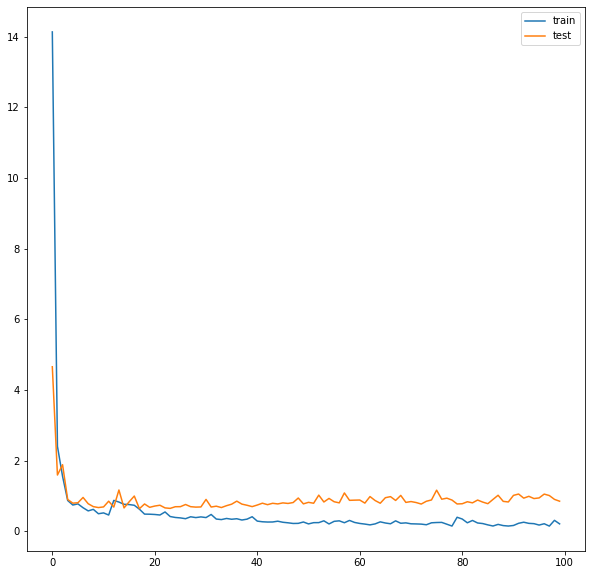

In [65]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(MLP.history['loss'],label = 'train')
plt.plot(MLP.history['val_loss'],label = 'test')
plt.legend()


In [66]:
predictions = np.round(model.predict(smiles_test))

In [67]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels_test, predictions)

In [68]:
import seaborn as sns


Text(0.5, 15.0, 'PREDICTED')

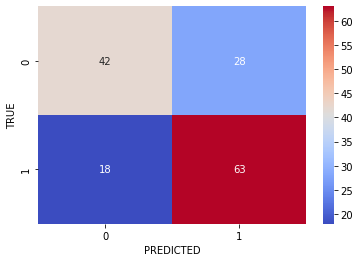

In [69]:
sns.heatmap(cm, annot=True,cmap='coolwarm')
plt.ylabel("TRUE")
plt.xlabel("PREDICTED")

In [70]:
tn, fp, fn, tp = confusion_matrix(labels_test, predictions).ravel()

In [60]:
tn, fp, fn, tp 

(0, 70, 0, 81)

In [71]:
tp/(tp+fn)

0.7777777777777778